## STOCK MARKET - Window method -LSTM


### Problem Description
The problem we are going to look at in this post is the stock market prices prediction problem.

This is a problem where, given a day, month, and a year, the task is to predict the price of next days stocks . The data ranges from 1996 to 2010,  with 4800 observations.

** Name of the Dataset **  “TATAMOTORS.BO.xlsx'“

In [140]:
import numpy
import pandas
import math

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import os


from keras.callbacks import ModelCheckpoint

In [141]:
dataset = pandas.read_excel('ETHUSD=X.xlsx', usecols=[0,4], skipfooter=3)
dataset.fillna(method='ffill', inplace=True)

dataset.head()

,Date,Close
0,2015-08-07,2.772120
1,2015-08-10,0.708448
2,2015-08-11,1.067860
3,2015-08-12,1.217440
4,2015-08-13,1.827670


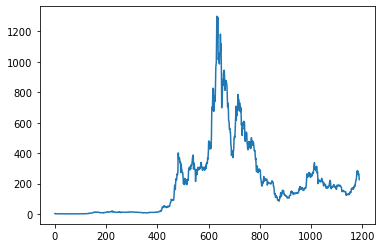

In [142]:
plt.plot(dataset['Close'])
plt.show()

***The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.***

There are three types of gates within a unit:
- **Forget Gate**: conditionally decides what information to throw away from the block.
- **Input Gate**: conditionally decides which values from the input to update the memory state.
- **Output Gate**: conditionally decides what to output based on input and the memory of the block.

### LMST Network Regression Types

- Simple : Given (t)    ====> predict (t+1)
- Window : Given (t-39 (t-38,..... (t-1), (t) =====> predict (t+1), (t+2) ... (t+10)
Window is used in our example


### Predict next 10 days(forward_days) depending on the previous 40 days (look_back) using LSTM Neural Networks

#### LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the price of stocks last 40 days, what is the price of stocks next 10 days?


We can write a simple function to convert our single column of data into a two-column dataset:
the first column containing these 40 days stocks stock count and the second column containing next 10 days stock price, to be predicted.

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible

In [143]:
# fix random seed for reproducibility
numpy.random.seed(7)

We can load this dataset easily using the Pandas library. <br>
We are not interested in the date, open price ... etc
given that each observation is separated by the same interval of one day. <br>
Therefore, when we load the dataset **we can exclude the other columns and keep only the close price**.

In [144]:
# load the dataset sales-of-soaps.csv
dataframe = pandas.read_excel('ETHUSD=X.xlsx', usecols=[4])
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python')
dataframe.fillna(method='ffill', inplace=True)

dataframe.head()
#print(type(dataframe.dtypes))

,Close
0,2.772120
1,0.708448
2,1.067860
3,1.217440
4,1.827670


- ** extract the NumPy array from the dataframe** <br>
- Then **convert the integer values to floating point values**, which are more suitable for modeling with a neural network.

In [145]:
dataset = dataframe.values      ##   convert the data-frame to its Numpy-array
dataset = dataset.astype('float32')

### Important:
**LSTMs** are sensitive to the scale of the input data, specifically when the ***sigmoid (default)*** or ***tanh*** activation functions are used. <br>
It can be a good practice to rescale the data to the range of 0-to-1, also called ** normalizing**.<br>
We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [146]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Doing a Train-Test Split<br>
Train: 67%<br>
Test:  33%

In [147]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

798 394


#### Cross Validation

##### When using time series data, the sequence of values is important. <br>

Now we can define a function to create a new dataset.

The function takes two arguments: the ***dataset***, which is a NumPy array that we want to convert into a dataset, and the ***look_back***, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 40.

This default will create a dataset where X is the  price of stocks last 40 days and Y is the price at the next 10 days.

It can be configured, and we will be constructing a differently shaped dataset in the next section.

In [148]:
forward_days = 10
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=40):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-forward_days+1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


Let’s use this function to prepare the train and test datasets for modeling.

In [149]:
# reshape into X=t and Y=t+1
look_back = 40

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [150]:
trainX.shape

(749, 40)

In [151]:
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [152]:
trainX.shape

(749, 40, 1)

We are now ready to design and fit our LSTM network for this problem.

The network has :<br>
- a visible layer with 1 input<br>
- a hidden layer with 4 LSTM blocks or neurons<br>
- an output layer that makes a single value prediction. <br>

The default sigmoid activation function is used for the LSTM blocks. <br>
The network is trained for 40 epochs and a batch size of 40 is used.

In [83]:
# create the LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))
from keras import optimizers
adam = optimizers. Adam(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

In [84]:
model.summary()
#model.load_weights('LSTM_weights.h5')
adam = optimizers. Adam(lr=0.0015, decay=1.5e-6)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 40, 8)             320       
_________________________________________________________________
lstm_17 (LSTM)               (None, 40, 8)             544       
_________________________________________________________________
lstm_18 (LSTM)               (None, 40, 8)             544       
_________________________________________________________________
lstm_19 (LSTM)               (None, 40, 8)             544       
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,505
Trainable params: 2,505
Non-trainable params: 0
____________________________________________________

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='LSTM_model_plot1.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('LSTM_model_plot1.png')
imgplot = plt.imshow(img)
plt.show()

#!pip install GraphViz 
import os
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='LSTM_model_plot2.png', show_shapes=True, show_layer_names=True)

In [153]:
%%time
# Fit the LSTM network
import keras
#mc = keras.callbacks.callbacks.ModelCheckpoint("mc", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=10)

#es = keras.callbacks.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


model.fit(trainX, trainY, epochs=150, batch_size=20, verbose=2) #, callbacks=[mc, es]


Epoch 1/150
 - 3s - loss: 2.8493e-04 - accuracy: 0.0013
Epoch 2/150
 - 2s - loss: 2.9236e-04 - accuracy: 0.0013
Epoch 3/150
 - 2s - loss: 2.4125e-04 - accuracy: 0.0013
Epoch 4/150
 - 2s - loss: 2.4166e-04 - accuracy: 0.0013
Epoch 5/150
 - 3s - loss: 2.6965e-04 - accuracy: 0.0013
Epoch 6/150
 - 3s - loss: 2.5690e-04 - accuracy: 0.0013
Epoch 7/150
 - 3s - loss: 2.9903e-04 - accuracy: 0.0013
Epoch 8/150
 - 3s - loss: 2.5630e-04 - accuracy: 0.0013
Epoch 9/150
 - 3s - loss: 2.5900e-04 - accuracy: 0.0013
Epoch 10/150
 - 3s - loss: 2.2301e-04 - accuracy: 0.0013
Epoch 11/150
 - 3s - loss: 2.5831e-04 - accuracy: 0.0013
Epoch 12/150
 - 3s - loss: 2.3687e-04 - accuracy: 0.0013
Epoch 13/150
 - 2s - loss: 2.1510e-04 - accuracy: 0.0013
Epoch 14/150
 - 2s - loss: 2.1344e-04 - accuracy: 0.0013
Epoch 15/150
 - 2s - loss: 2.4754e-04 - accuracy: 0.0013
Epoch 16/150
 - 2s - loss: 2.6013e-04 - accuracy: 0.0013
Epoch 17/150
 - 2s - loss: 2.6273e-04 - accuracy: 0.0013
Epoch 18/150
 - 2s - loss: 2.2016e-04 - 

 - 2s - loss: 1.8058e-04 - accuracy: 0.0013
Epoch 145/150
 - 2s - loss: 1.8234e-04 - accuracy: 0.0013
Epoch 146/150
 - 2s - loss: 1.5117e-04 - accuracy: 0.0013
Epoch 147/150
 - 2s - loss: 1.6861e-04 - accuracy: 0.0013
Epoch 148/150
 - 2s - loss: 1.6525e-04 - accuracy: 0.0013
Epoch 149/150
 - 2s - loss: 1.8073e-04 - accuracy: 0.0013
Epoch 150/150
 - 2s - loss: 1.6908e-04 - accuracy: 0.0013
Wall time: 5min 42s


Once the model is fit, we can estimate the performance of the model on the train and test datasets.

In [154]:
#model.save_weights('LSTM_weights.h5')


scores = model.evaluate(trainX, trainY, verbose=0)
print(scores)
print(model.metrics_names)


[0.00015760414929383152, 0.0013351135421544313]
['loss', 'accuracy']


In [155]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


***Note that we invert the predictions before calculating error scores 
to ensure that performance is reported in the same units as the original data (thousands of passengers per month).***

In [156]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [157]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

Train Score: 266.07 MSE
Test Score: 298.32 MSE


In [158]:
## Train Score: 23.70 RMSE Test Score: 58.87 RMSE (LSTM - 4) Lookback-3
## Train Score: 13.53 RMSE Test Score: 37.48 RMSE (LSTM - 64) Lookback-12

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [132]:
datedate = pandas.read_excel('ETHUSD=X.xlsx', usecols=[0], skipfooter=3)


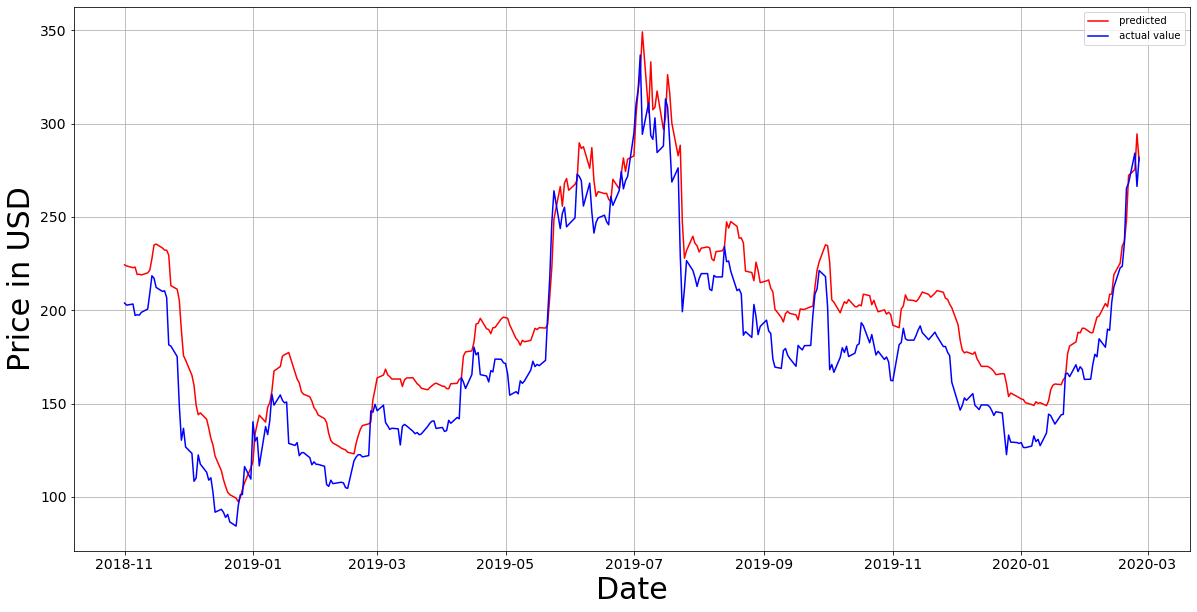

In [139]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(datedate.tail(345),testPredict, label=' predicted', color='red')
plt.plot(datedate.tail(345),testY[0], label=' actual value', color='blue')

plt.xlabel('Date', fontsize=30)
plt.ylabel('Price in USD', fontsize=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend()

plt.show()